#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행 
    * 성능 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.

## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re

# 필요하다고 판단되는 라이브러리를 추가하세요.
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

* 함수 생성

In [3]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - 데이터프레임에 대한 기본 정보를 확인합니다.( .head(), .shape 등)

#### 1) 데이터 로딩

In [104]:
data = pd.read_csv('data01_train.csv')
data = data.drop('subject', axis = 1)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [5]:
data.shape

(5881, 562)

#### 2) 기본 정보 조회

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tBodyAcc-mean()-X,5881.0,0.274811,0.067614,-0.503823,0.262919,0.277154,0.288526,1.000000
tBodyAcc-mean()-Y,5881.0,-0.017799,0.039422,-0.684893,-0.024877,-0.017221,-0.010920,1.000000
tBodyAcc-mean()-Z,5881.0,-0.109396,0.058373,-1.000000,-0.121051,-0.108781,-0.098163,1.000000
tBodyAcc-std()-X,5881.0,-0.603138,0.448807,-1.000000,-0.992774,-0.943933,-0.242130,1.000000
tBodyAcc-std()-Y,5881.0,-0.509815,0.501815,-0.999844,-0.977680,-0.844575,-0.034499,0.916238
...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",5881.0,0.009340,0.608190,-1.000000,-0.481718,0.011448,0.499857,0.998702
"angle(tBodyGyroJerkMean,gravityMean)",5881.0,-0.007099,0.476738,-1.000000,-0.373345,-0.000847,0.356236,0.996078
"angle(X,gravityMean)",5881.0,-0.491501,0.509069,-1.000000,-0.811397,-0.709441,-0.511330,0.977344
"angle(Y,gravityMean)",5881.0,0.059299,0.297340,-1.000000,-0.018203,0.182893,0.248435,0.478157


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다. 


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [105]:
target = 'Activity'
X = data.drop(target, axis = 1)
y = data.loc[:, target]

In [107]:
data2 = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

target = 'Activity'
X2 = data2.drop(target, axis = 1)
y2 = data2.loc[:, target]

In [108]:
y3 = y.map({'LAYING' : 0,  'SITTING' : 1, 'STANDING' : 2, 'WALKING' : 3, 'WALKING_DOWNSTAIRS' : 4, 'WALKING_UPSTAIRS' : 5})
y3

0       2
1       0
2       2
3       3
4       4
       ..
5876    1
5877    5
5878    0
5879    5
5880    1
Name: Activity, Length: 5881, dtype: int64

### (2) 스케일링(필요시)


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
####

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [109]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42) # 기본
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size = 0.2, random_state = 42) # 변수 이름에서 특수기호 제거
X_train3, X_val3, y_train3, y_val3 = train_test_split(X, y3, test_size = 0.2, random_state = 42) # target 0 ~ 5로 변경

## **3. 기본 모델링**



* 세부 요구사항
    - 최소 4개 이상의 알고리즘을 적용하여 모델링을 수행한다. 
    - 각 알고리즘별로 전체 변수로 모델링, 상위 N개 변수를 선택하여 모델링을 수행하고 성능 비교를 한다.
    - (옵션) 알고리즘 중 1~2개에 대해서, 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것이다.

### (1) 알고리즘1 : RandomForest

#### 전체 변수

In [125]:
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)
p_rf_1 = model_rf.predict(X_val)

print(accuracy_score(y_val, p_rf_1))
print(confusion_matrix(y_val, p_rf_1))
print(classification_report(y_val, p_rf_1))

0.9796091758708582
[[231   0   0   0   0   0]
 [  0 195   5   0   0   0]
 [  0   9 217   0   0   0]
 [  0   0   0 194   2   2]
 [  0   0   0   3 141   1]
 [  0   0   0   0   2 175]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       231
           SITTING       0.96      0.97      0.97       200
          STANDING       0.98      0.96      0.97       226
           WALKING       0.98      0.98      0.98       198
WALKING_DOWNSTAIRS       0.97      0.97      0.97       145
  WALKING_UPSTAIRS       0.98      0.99      0.99       177

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



In [121]:
rf = plot_feature_importance(model_rf.feature_importances_, list(X_train), True)
rf.head()

,feature_name,feature_importance
0,tGravityAcc-mean()-X,0.037706
1,"angle(X,gravityMean)",0.030092
2,tGravityAcc-max()-X,0.029231
3,tGravityAcc-mean()-Y,0.025261
4,tGravityAcc-max()-Y,0.024912


#### 상위 변수 n개

In [122]:
acc = []
for i in range(200) :   # 전체 변수는 561이지만, 200 정도면 충분하다
    top_n_feature = rf.loc[:i, 'feature_name']
    X_train_n = X_train[top_n_feature]
    X_val_n = X_val[top_n_feature]
    model_rf.fit(X_train_n, y_train)
    pred = model_rf.predict(X_val_n)
    acc.append(accuracy_score(y_val, pred))

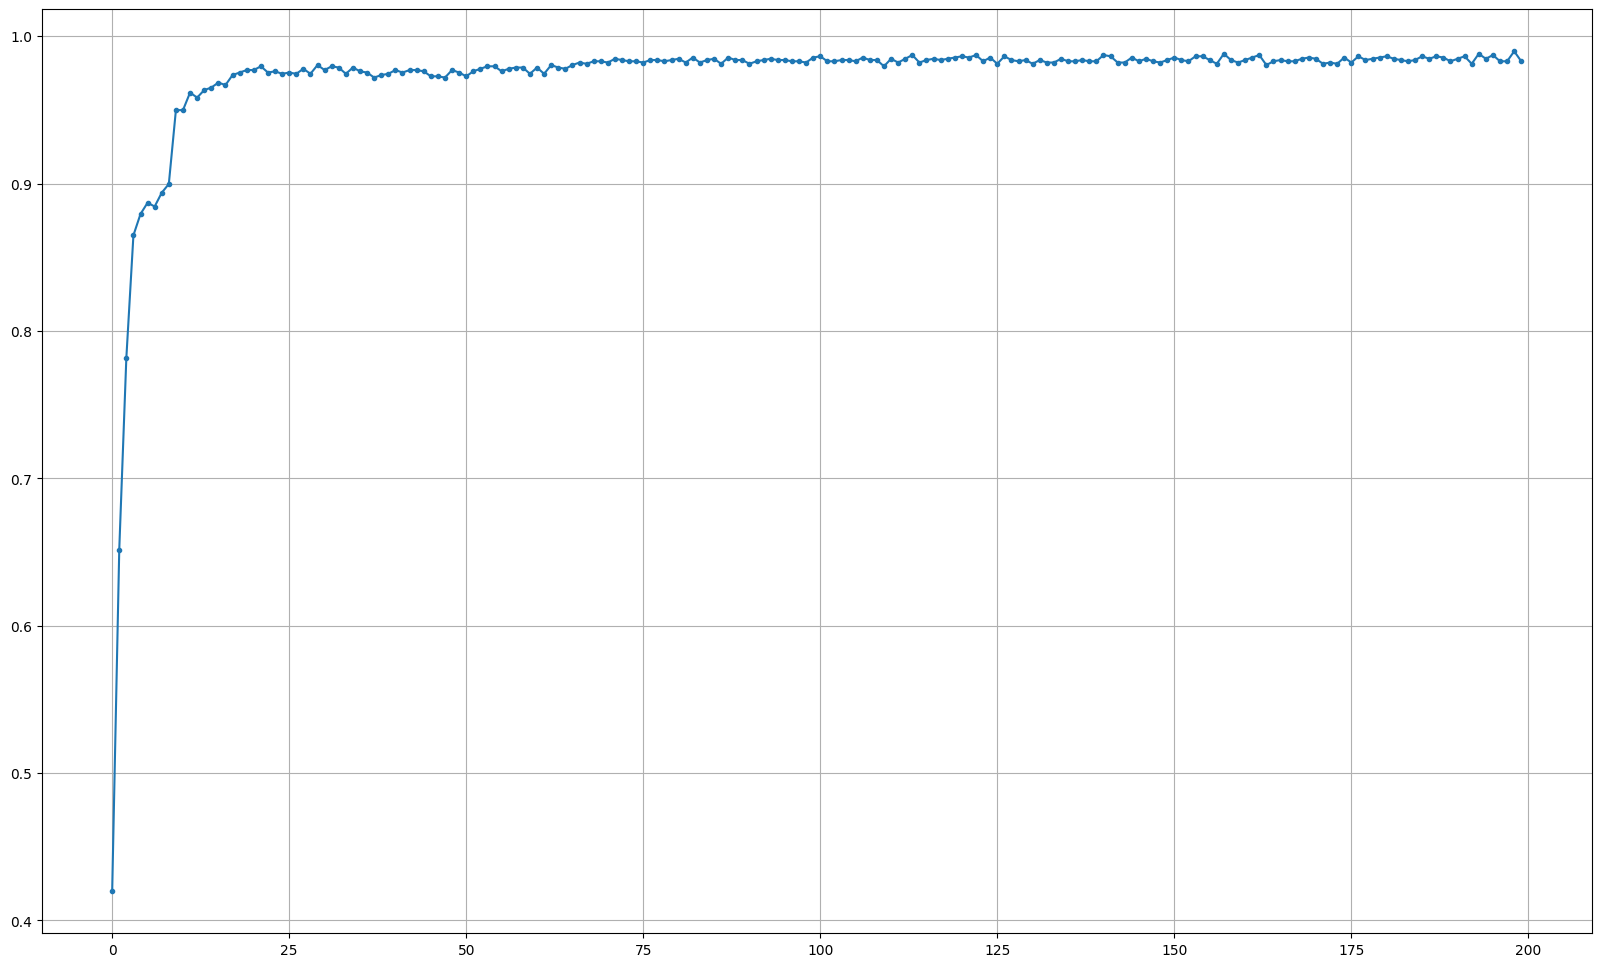

In [124]:
plt.figure(figsize = (20,12))
plt.plot(range(200), acc, marker = '.')
plt.grid()
plt.show()

In [128]:
print('Max accuracy : ', max(acc))
print('best_num_features : ', acc.index(max(acc)))

Max accuracy :  0.989804587935429
best_num_features :  198


- 변수 상위 198개 선정

In [129]:
top_198_feature = rf.loc[:198, 'feature_name']
X_train_198 = X_train[top_198_feature]
X_val_198 = X_val[top_198_feature]

model_rf.fit(X_train_198, y_train)
p_rf_2 = model_rf.predict(X_val_198)

print('accuracy :',accuracy_score(y_val, p_rf_2))
print('='*60)
print(confusion_matrix(y_val, p_rf_2))
print('='*60)
print(classification_report(y_val, p_rf_2))

accuracy : 0.989804587935429
[[231   0   0   0   0   0]
 [  0 198   2   0   0   0]
 [  0   4 222   0   0   0]
 [  0   0   0 194   2   2]
 [  0   0   0   1 144   0]
 [  0   0   0   0   1 176]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       231
           SITTING       0.98      0.99      0.99       200
          STANDING       0.99      0.98      0.99       226
           WALKING       0.99      0.98      0.99       198
WALKING_DOWNSTAIRS       0.98      0.99      0.99       145
  WALKING_UPSTAIRS       0.99      0.99      0.99       177

          accuracy                           0.99      1177
         macro avg       0.99      0.99      0.99      1177
      weighted avg       0.99      0.99      0.99      1177



### (2) 알고리즘2 : XGBoost

#### 전체 변수

In [130]:
model_xgb = XGBClassifier(random_state = 42, device = 'gpu')
model_xgb.fit(X_train3, y_train3)
p_xgb_1 = model_xgb.predict(X_val3)

print(accuracy_score(y_val3, p_xgb_1))
print(confusion_matrix(y_val3, p_xgb_1))
print(classification_report(y_val3, p_xgb_1))

0.9932030586236194
[[231   0   0   0   0   0]
 [  0 198   2   0   0   0]
 [  0   3 223   0   0   0]
 [  0   0   0 195   1   2]
 [  0   0   0   0 145   0]
 [  0   0   0   0   0 177]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       231
           1       0.99      0.99      0.99       200
           2       0.99      0.99      0.99       226
           3       1.00      0.98      0.99       198
           4       0.99      1.00      1.00       145
           5       0.99      1.00      0.99       177

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177



In [131]:
xgb = plot_feature_importance(model_xgb.feature_importances_, list(X_train3), True)
xgb.head()

,feature_name,feature_importance
0,fBodyAcc-skewness()-X,0.073452
1,"angle(X,gravityMean)",0.066220
2,tBodyAcc-iqr()-X,0.061089
3,fBodyAccMag-mad(),0.057470
4,fBodyBodyAccJerkMag-max(),0.038606


#### 상위 변수 n개

In [133]:
acc = []
for i in range(200) :   # 전체 변수는 561이지만, 200 정도면 충분하다
    top_n_feature = xgb.loc[:i, 'feature_name']
    X_train_n = X_train3[top_n_feature]
    X_val_n = X_val3[top_n_feature]
    model_xgb.fit(X_train_n, y_train3)
    pred = model_xgb.predict(X_val_n)
    acc.append(accuracy_score(y_val3, pred))
    print(i, end = ' ')
    if i % 20 == 0:
        print()

0 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 
41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 
61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 
81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 
121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 
141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 
161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 
181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

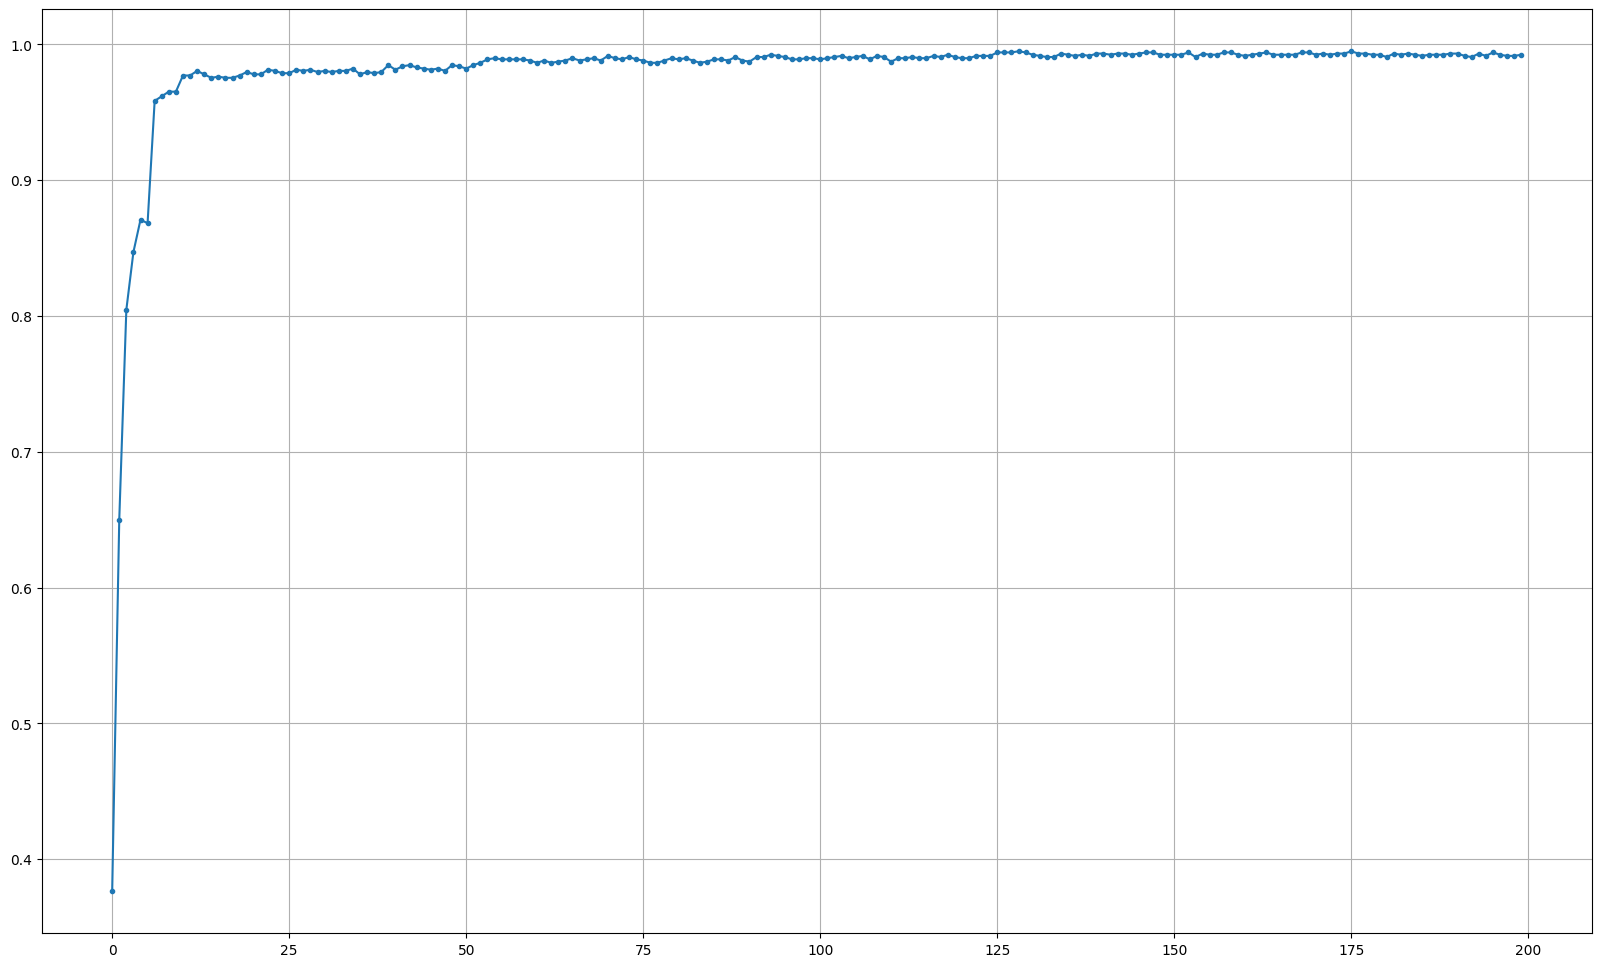

In [134]:
plt.figure(figsize = (20,12))
plt.plot(range(200), acc, marker = '.')
plt.grid()
plt.show()

In [135]:
print('Max accuracy : ', max(acc))
print('best_num_features : ', acc.index(max(acc)))

Max accuracy :  0.9949022939677146
best_num_features :  128


- 변수 상위 128개 선정

In [137]:
top_128_feature = xgb.loc[:128, 'feature_name']
X_train_128 = X_train3[top_128_feature]
X_val_128 = X_val3[top_128_feature]

model_xgb.fit(X_train_128, y_train3)
p_xgb_2 = model_xgb.predict(X_val_128)

print('accuracy :',accuracy_score(y_val3, p_xgb_2))
print('='*60)
print(confusion_matrix(y_val3, p_xgb_2))
print('='*60)
print(classification_report(y_val3, p_xgb_2))

accuracy : 0.9949022939677146
[[231   0   0   0   0   0]
 [  0 200   0   0   0   0]
 [  0   3 223   0   0   0]
 [  0   0   0 197   0   1]
 [  0   0   0   1 144   0]
 [  0   0   0   0   1 176]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       231
           1       0.99      1.00      0.99       200
           2       1.00      0.99      0.99       226
           3       0.99      0.99      0.99       198
           4       0.99      0.99      0.99       145
           5       0.99      0.99      0.99       177

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177



### (3) 알고리즘3 : LightGBM

#### 전체 변수

In [138]:
model_lgb = LGBMClassifier(random_state = 42, verbose = -1, device = 'gpu')
model_lgb.fit(X_train2, y_train2)
p_lgb_1 = model_lgb.predict(X_val2)

print(accuracy_score(y_val2, p_lgb_1))
print(confusion_matrix(y_val2, p_lgb_1))
print(classification_report(y_val2, p_lgb_1))

0.9949022939677146
[[231   0   0   0   0   0]
 [  0 198   2   0   0   0]
 [  0   2 224   0   0   0]
 [  0   0   0 196   0   2]
 [  0   0   0   0 145   0]
 [  0   0   0   0   0 177]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       231
           SITTING       0.99      0.99      0.99       200
          STANDING       0.99      0.99      0.99       226
           WALKING       1.00      0.99      0.99       198
WALKING_DOWNSTAIRS       1.00      1.00      1.00       145
  WALKING_UPSTAIRS       0.99      1.00      0.99       177

          accuracy                           0.99      1177
         macro avg       0.99      1.00      1.00      1177
      weighted avg       0.99      0.99      0.99      1177



In [139]:
lgb = plot_feature_importance(model_lgb.feature_importances_, list(X_train2), True)
lgb.head()

,feature_name,feature_importance
0,tGravityAccminY,407
1,tGravityAccenergyY,394
2,tBodyAcccorrelationXY,266
3,tGravityAccmaxY,240
4,tBodyGyrocorrelationYZ,228


#### 상위 변수 n개

In [140]:
acc = []
for i in range(200) :   # 전체 변수는 561이지만, 200 정도면 충분하다
    top_n_feature = lgb.loc[:i, 'feature_name']
    X_train_n = X_train2[top_n_feature]
    X_val_n = X_val2[top_n_feature]
    model_lgb.fit(X_train_n, y_train2)
    pred = model_lgb.predict(X_val_n)
    acc.append(accuracy_score(y_val2, pred))
    print(i, end = ' ')
    if i % 20 == 0:
        print()

0 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 
41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 
61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 
81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 
121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 
141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 
161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 
181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

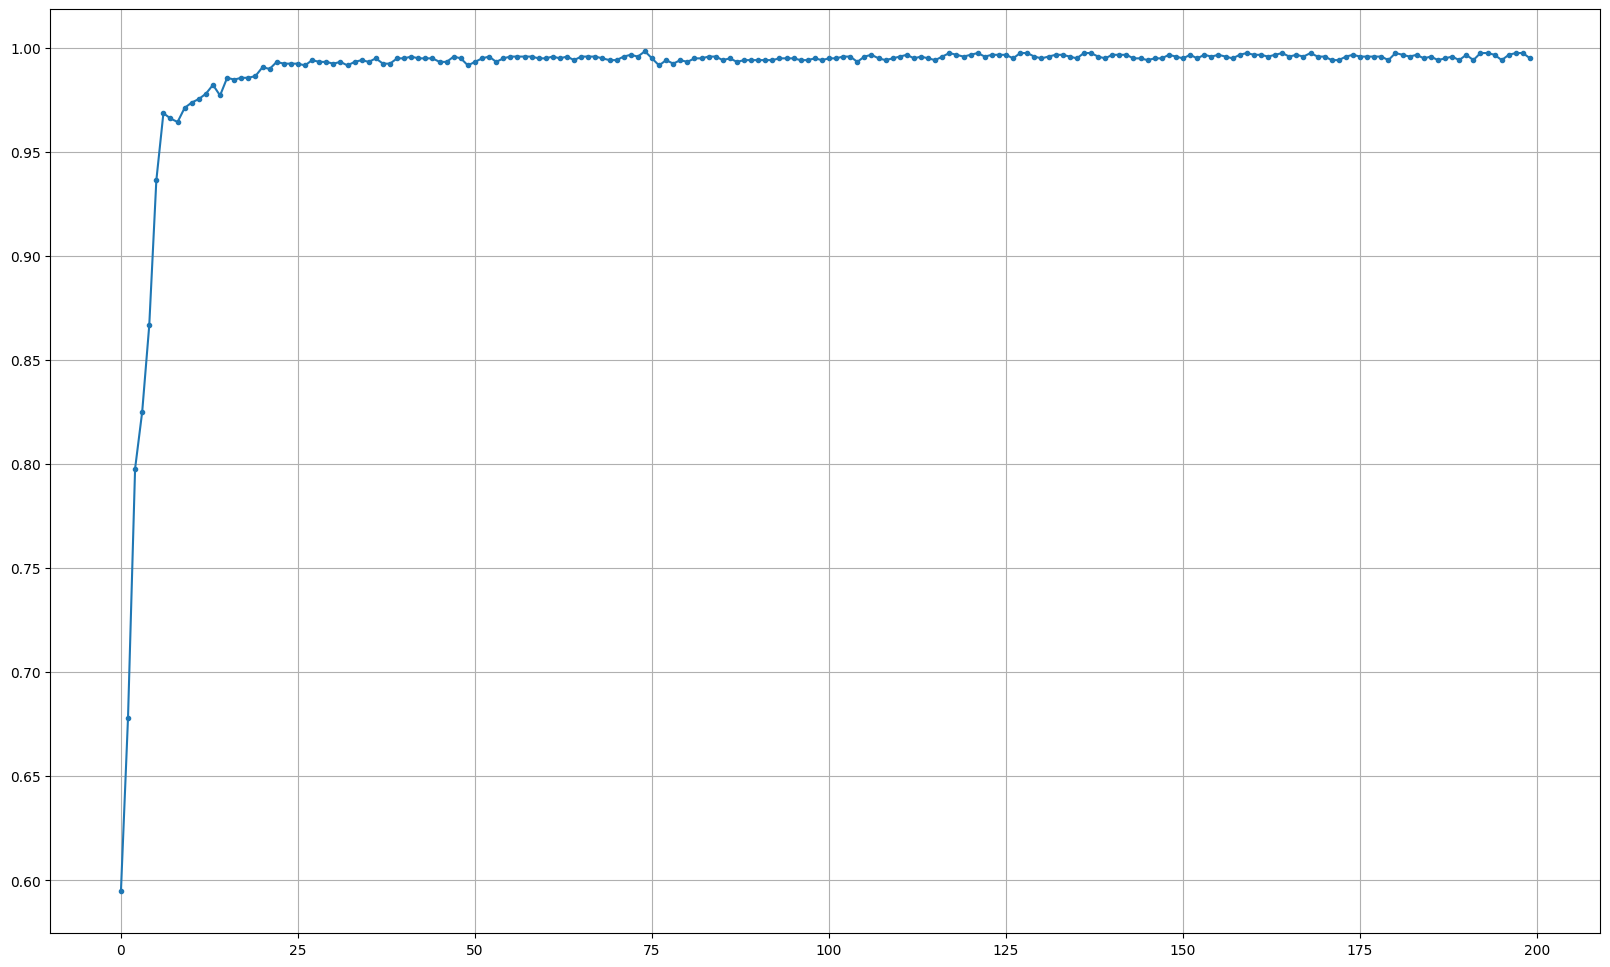

In [141]:
plt.figure(figsize = (20,12))
plt.plot(range(200), acc, marker = '.')
plt.grid()
plt.show()

In [142]:
print('Max accuracy : ', max(acc))
print('best_num_features : ', acc.index(max(acc)))

Max accuracy :  0.9983007646559049
best_num_features :  74


- 변수 상위 74개 선정

In [145]:
top_74_feature = lgb.loc[:74, 'feature_name']
X_train_74 = X_train2[top_74_feature]
X_val_74 = X_val2[top_74_feature]

model_lgb.fit(X_train_74, y_train2)
p_lgb_2 = model_lgb.predict(X_val_74)

print('accuracy :',accuracy_score(y_val2, p_lgb_2))
print('='*60)
print(confusion_matrix(y_val2, p_lgb_2))
print('='*60)
print(classification_report(y_val2, p_lgb_2))

accuracy : 0.9966015293118097
[[231   0   0   0   0   0]
 [  0 199   1   0   0   0]
 [  0   2 224   0   0   0]
 [  0   0   0 197   1   0]
 [  0   0   0   0 145   0]
 [  0   0   0   0   0 177]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       231
           SITTING       0.99      0.99      0.99       200
          STANDING       1.00      0.99      0.99       226
           WALKING       1.00      0.99      1.00       198
WALKING_DOWNSTAIRS       0.99      1.00      1.00       145
  WALKING_UPSTAIRS       1.00      1.00      1.00       177

          accuracy                           1.00      1177
         macro avg       1.00      1.00      1.00      1177
      weighted avg       1.00      1.00      1.00      1177



### (4) 알고리즘4 : CatBoost

#### 전체 변수

In [146]:
model_cat = CatBoostClassifier(random_state = 42, task_type = 'GPU', verbose = 0)
model_cat.fit(X_train, y_train)
p_cat_1 = model_cat.predict(X_val)

print(accuracy_score(y_val, p_cat_1))
print(confusion_matrix(y_val, p_cat_1))
print(classification_report(y_val, p_cat_1))

0.9932030586236194
[[231   0   0   0   0   0]
 [  0 198   2   0   0   0]
 [  0   4 222   0   0   0]
 [  0   0   0 197   0   1]
 [  0   0   0   1 144   0]
 [  0   0   0   0   0 177]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       231
           SITTING       0.98      0.99      0.99       200
          STANDING       0.99      0.98      0.99       226
           WALKING       0.99      0.99      0.99       198
WALKING_DOWNSTAIRS       1.00      0.99      1.00       145
  WALKING_UPSTAIRS       0.99      1.00      1.00       177

          accuracy                           0.99      1177
         macro avg       0.99      0.99      0.99      1177
      weighted avg       0.99      0.99      0.99      1177



In [147]:
cat = plot_feature_importance(model_cat.feature_importances_, list(X_train), True)
cat.head()

,feature_name,feature_importance
0,tBodyAccJerk-mad()-X,9.525623
1,fBodyAccJerk-max()-X,7.495311
2,tGravityAcc-max()-Y,5.002622
3,tGravityAcc-energy()-Y,4.796621
4,"tGravityAcc-arCoeff()-Y,1",4.411690


#### 상위 변수 n개

In [148]:
acc = []
for i in range(200) :   # 전체 변수는 561이지만, 200 정도면 충분하다
    top_n_feature = cat.loc[:i, 'feature_name']
    X_train_n = X_train[top_n_feature]
    X_val_n = X_val[top_n_feature]
    model_cat.fit(X_train_n, y_train)
    pred = model_cat.predict(X_val_n)
    acc.append(accuracy_score(y_val, pred))
    print(i, end = ' ')
    if i % 20 == 0:
        print()

0 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 
41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 
61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 
81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 
121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 
141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 
161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 
181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

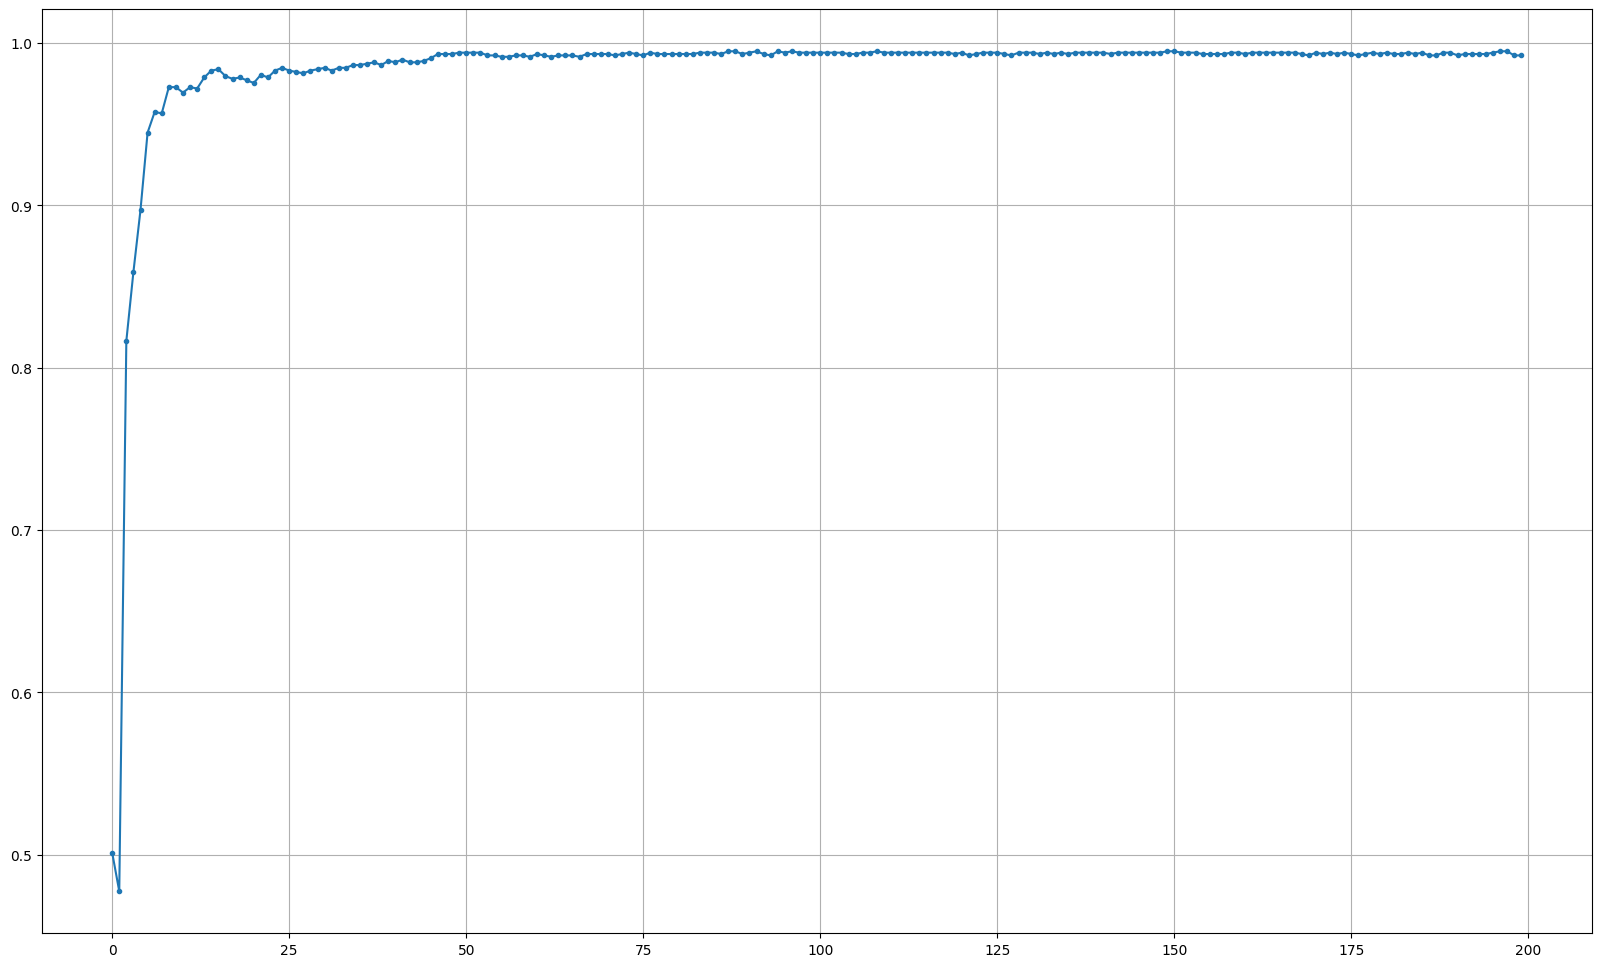

In [149]:
plt.figure(figsize = (20,12))
plt.plot(range(200), acc, marker = '.')
plt.grid()
plt.show()

In [150]:
print('Max accuracy : ', max(acc))
print('best_num_features : ', acc.index(max(acc)))

Max accuracy :  0.9949022939677146
best_num_features :  87


- 변수 상위 87개 선정

In [152]:
top_87_feature = cat.loc[:87, 'feature_name']
X_train_87 = X_train[top_87_feature]
X_val_87 = X_val[top_87_feature]

model_cat.fit(X_train_87, y_train)
p_cat_2 = model_cat.predict(X_val_87)

print('accuracy :',accuracy_score(y_val, p_cat_2))
print('='*60)
print(confusion_matrix(y_val, p_cat_2))
print('='*60)
print(classification_report(y_val, p_cat_2))

accuracy : 0.9949022939677146
[[231   0   0   0   0   0]
 [  0 199   1   0   0   0]
 [  0   3 223   0   0   0]
 [  0   0   0 197   0   1]
 [  0   0   0   1 144   0]
 [  0   0   0   0   0 177]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       231
           SITTING       0.99      0.99      0.99       200
          STANDING       1.00      0.99      0.99       226
           WALKING       0.99      0.99      0.99       198
WALKING_DOWNSTAIRS       1.00      0.99      1.00       145
  WALKING_UPSTAIRS       0.99      1.00      1.00       177

          accuracy                           0.99      1177
         macro avg       1.00      0.99      0.99      1177
      weighted avg       0.99      0.99      0.99      1177



### 5) 성능 비교

In [154]:
algorithm = ['RF','RF_198', 'XGB', 'XGB_128', 'LGBM', 'LGBM_74', 'CAT', 'CAT_87']
pred = [p_rf_1, p_rf_2, p_xgb_1, p_xgb_2, p_lgb_1, p_lgb_2, p_cat_1, p_cat_2]

result = pd.DataFrame({'algorithm':[],'accuracy':[],'f1_0':[],'f1_1':[],'f1_2':[],'f1_3':[],'f1_4':[],'f1_5':[]})

for i in range(8) :
    if i < 2 or i > 5 :
        acc = accuracy_score(y_val, pred[i])
        f1 = list(f1_score(y_val, pred[i], average = None))
    elif 2 <= i <= 3 :
        acc = accuracy_score(y_val3, pred[i])
        f1 = list(f1_score(y_val3, pred[i], average = None))
    else:
        acc = accuracy_score(y_val2, pred[i])
        f1 = list(f1_score(y_val2, pred[i], average = None))
        
    row = [algorithm[i], acc]
    result.loc[i] = row + f1

result

,algorithm,accuracy,f1_0,f1_1,f1_2,f1_3,f1_4,f1_5
0,RF,0.979609,1.0,0.965347,0.968750,0.982278,0.972414,0.985915
1,RF_198,0.989805,1.0,0.985075,0.986667,0.987277,0.986301,0.991549
2,XGB,0.993203,1.0,0.987531,0.988914,0.992366,0.996564,0.994382
3,XGB_128,0.994902,1.0,0.992556,0.993318,0.994949,0.993103,0.994350
4,LGBM,0.994902,1.0,0.990000,0.991150,0.994924,1.000000,0.994382
5,LGBM_74,0.996602,1.0,0.992519,0.993348,0.997468,0.996564,1.000000
6,CAT,0.993203,1.0,0.985075,0.986667,0.994949,0.996540,0.997183
7,CAT_87,0.994902,1.0,0.990050,0.991111,0.994949,0.996540,0.997183
